## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [4]:
from nndl import Softmax

In [5]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [7]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [8]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Since the weights have been initialized at random, there is around a 1/10 chance that the classifier predicts an input image's class correctly. Therefore, the softmax function will return approximatly 1/10, of which we take the log for the loss function and get -log(1/10) which is around 2.3.

#### Softmax gradient

In [13]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -1.002885 analytic: -1.002885, relative error: 2.129165e-09
numerical: 0.069499 analytic: 0.069499, relative error: 2.258907e-07
numerical: 0.913719 analytic: 0.913719, relative error: 3.455543e-09
numerical: 0.561850 analytic: 0.561850, relative error: 3.574384e-10
numerical: -0.243901 analytic: -0.243901, relative error: 2.155266e-07
numerical: 1.106812 analytic: 1.106812, relative error: 2.926994e-08
numerical: 0.357237 analytic: 0.357237, relative error: 6.844256e-08
numerical: -2.172427 analytic: -2.172427, relative error: 5.036179e-09
numerical: -1.649068 analytic: -1.649068, relative error: 5.232190e-09
numerical: -1.095710 analytic: -1.095710, relative error: 4.729251e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [14]:
import time

In [28]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3422220643301808 / 282.0786751924475 computed in 0.10903811454772949s
Vectorized loss / grad: 2.3422220643301817 / 282.0786751924475 computed in 0.0261843204498291s
difference in loss / grad: -8.881784197001252e-16 /2.466349875728883e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The gradient descent training step is the same between the two models because both essentially calculate the gradient and take a step in the direction of steepest descent. The results are different due to different loss functions, but the overall training steps should be the same.

iteration 0 / 1500: loss 2.336592660663754
iteration 100 / 1500: loss 2.0557222613850827
iteration 200 / 1500: loss 2.0357745120662813
iteration 300 / 1500: loss 1.9813348165609888
iteration 400 / 1500: loss 1.9583142443981614
iteration 500 / 1500: loss 1.8622653073541355
iteration 600 / 1500: loss 1.8532611454359382
iteration 700 / 1500: loss 1.8353062223725827
iteration 800 / 1500: loss 1.8293892468827635
iteration 900 / 1500: loss 1.899215853035748
iteration 1000 / 1500: loss 1.9783503540252299
iteration 1100 / 1500: loss 1.8470797913532633
iteration 1200 / 1500: loss 1.8411450268664082
iteration 1300 / 1500: loss 1.7910402495792102
iteration 1400 / 1500: loss 1.8705803029382257
That took 15.612247228622437s


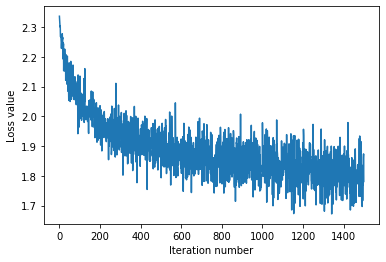

In [29]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [30]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3811428571428571
validation accuracy: 0.398


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [31]:
np.finfo(float).eps

2.220446049250313e-16

In [36]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-1]
val_accuracies = []

sm = Softmax()
for i, rate in enumerate(learning_rates):
    sm.train(X_train, y_train, learning_rate=rate, num_iters=1500, verbose=False)
    predictions = sm.predict(X_val)
    accuracy = np.mean(np.equal(predictions, y_val))
    val_accuracies.append(accuracy)
    print('rate={}: accuracy={}, error={}'.format(rate, accuracy, 1-accuracy))
    

best_rate = learning_rates[np.argmax(val_accuracies)]
best_accuracy = np.max(val_accuracies)
sm.train(X_train, y_train, learning_rate=best_rate, num_iters=1500, verbose=False)
test_error = 1 - np.mean(np.equal(sm.predict(X_test), y_test))

print()
print('Best learning rate:', best_rate)
print('Best validation accuracy:', best_accuracy)
print('Test error with best learning rate:', test_error)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


rate=1e-08: accuracy=0.308, error=0.692
rate=1e-07: accuracy=0.386, error=0.614
rate=1e-06: accuracy=0.412, error=0.5880000000000001
rate=1e-05: accuracy=0.291, error=0.7090000000000001
rate=0.0001: accuracy=0.283, error=0.7170000000000001
rate=0.001: accuracy=0.087, error=0.913
rate=0.1: accuracy=0.087, error=0.913

Best learning rate: 1e-06
Best validation accuracy: 0.412
Test error with best learning rate: 0.617
